# Starcraft Player Rank Prediction 

The problem statement says that we want to develop a model to predict a player’s rank using the information provided in the Starcraft player performance data in ranked games. Over 25 years in the industry with StarCraft and StarCraft II, the game is very popular among the youth

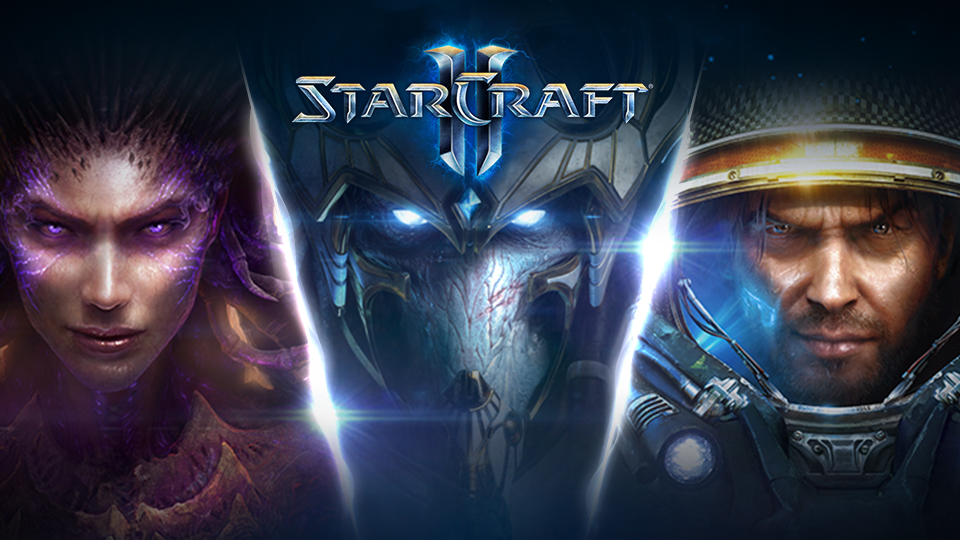

### In order to understand the more about the data, let us start by importing all the necesary dependencies

In [1004]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler, RobustScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

from itertools import cycle
from glob import glob
from pathlib import Path
import joblib
import pickle
import os
import random
from scipy.stats import randint, uniform

import time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

### The libraries I will be using to analyze this data are-

**1. Pandas:** Pandas is a powerful library for data manipulation and analysis. It provides data structures like DataFrames for efficient handling and analysis of structured data.

**2. NumPy:** NumPy is a fundamental library for scientific computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

**3. Matplotlib:** Matplotlib is a widely-used plotting library in Python. It provides a flexible and comprehensive set of functions for creating various types of visualizations, including line plots, scatter plots, bar plots, histograms, and more.

**4. Plotly:** Plotly is an interactive visualization library that allows you to create interactive and dynamic plots. It provides a rich set of tools for creating interactive charts, graphs, and dashboards that can be embedded in web applications or notebooks.

**5. Seaborn:** Seaborn is a high-level data visualization library based on Matplotlib. It provides a simplified interface and additional functionality for creating attractive statistical graphics. Seaborn is particularly useful for visualizing relationships and distributions in complex datasets.

**6. tqdm:** tqdm is a library for adding progress bars to your loops and tasks in Python. It provides a simple and convenient way to track the progress of your code execution and estimate the remaining time.

**7. scikit-learn:** scikit-learn is a comprehensive machine learning library in Python. It provides a wide range of algorithms and tools for tasks such as classification, regression, clustering, dimensionality reduction, and model selection. It also includes utilities for data preprocessing, model evaluation, and cross-validation.

**8. imbalanced-learn:** imbalanced-learn is a Python library specifically designed to tackle imbalanced classification problems. It provides various techniques for resampling the imbalanced datasets, such as oversampling the minority class (e.g., SMOTE) or undersampling the majority class.

**9. LightGBM:** LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be efficient, scalable, and accurate. LightGBM can handle large datasets and provides faster training and better performance compared to other gradient boosting implementations.

**10. XGBoost:** XGBoost is another popular gradient boosting library that excels in performance and speed. It is widely used in machine learning competitions and is known for its high predictive accuracy. XGBoost supports both regression and classification tasks and offers a variety of advanced features, including regularization, parallel processing, and tree pruning.

In [848]:
df = pd.read_csv('C:/Users/shaur/Downloads/EG Assessment/starcraft_player_data.csv')

## Understanding the Data

Let try to understand the data from a statistical point of view

In [849]:
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [850]:
df.shape

(3395, 20)

In [851]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

- There are 3395 rows with no missing values in the dataset. 
- Most of the variables are in INT or FLOAT format
- It is interesting to see Age, HoursPerWeek and TotalHours as object types

### Fixing Age, HoursPerWeek and TotalHours

In [852]:
def convertObjToInt(df, column):
    df[column] = df[column].astype(int)
# convertObjToInt(df, 'Age')
# convertObjToInt(df, 'HoursPerWeek')
# convertObjToInt(df, 'TotalHours')

There are some values as '?' in the dataset. Let us deal with them by modifing the function

In [853]:
def convertObjToInt(df):
    for column in df.columns:
        if df[column].dtype=='object':
            df[column] = pd.to_numeric(df[column], errors='coerce')
            df[column] = df[column].astype(pd.Int64Dtype(), errors='ignore')
convertObjToInt(df)

**We have converted all data types to Int, Float**

In [854]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3340 non-null   Int64  
 3   HoursPerWeek          3339 non-null   Int64  
 4   TotalHours            3338 non-null   Int64  
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

### Creating a Summary Table Function

Now let us do a statistical analysis of the data. We will try to find out-
- Data Type
- Number of Missing Values
- Percentage of Missing Valeus
- Number of Unique Values
- Minimum Value
- Maximum Value
- First Quartile
- Second Quartie
- Third quartile

In [855]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first quartile'] = desc.loc[:, '25%'].values
    summ['second quartile'] = desc.loc[:, '50%'].values
    summ['third quartile'] = desc.loc[:, '75%'].values
    
    return summ
summary(df)

data shape: (3395, 20)


,data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
GameID,int64,0,0.000000,3395,52.0,10095.0,2464.5,4874.0,7108.5
LeagueIndex,int64,0,0.000000,8,1.0,8.0,3.0,4.0,5.0
Age,Int64,55,1.620029,28,16.0,44.0,19.0,21.0,24.0
HoursPerWeek,Int64,56,1.649485,32,0.0,168.0,8.0,12.0,20.0
TotalHours,Int64,57,1.678940,237,3.0,1000000.0,300.0,500.0,800.0
APM,float64,0,0.000000,3374,22.0596,389.8314,79.9002,108.0102,142.7904
SelectByHotkeys,float64,0,0.000000,3375,0.0,0.043088,0.001258,0.0025,0.005133
AssignToHotkeys,float64,0,0.000000,3361,0.0,0.001752,0.000204,0.000353,0.000499
UniqueHotkeys,int64,0,0.000000,11,0.0,10.0,3.0,4.0,6.0
MinimapAttacks,float64,0,0.000000,2471,0.0,0.003019,0.0,0.00004,0.000119


It's interesting to see data of aged 44 players, we will do a better analysis during EDA. Some extreme values do not make a lot of sense. For example, having an APM of 390 seems literally impossible.

In general, the trend I'm noticing is a big gap between the third quartile and extreme values, which may possess a threat of outliers. I would prefer tree based approaches to solve this problem.

**Let us figure out the Correlations between independent variables**

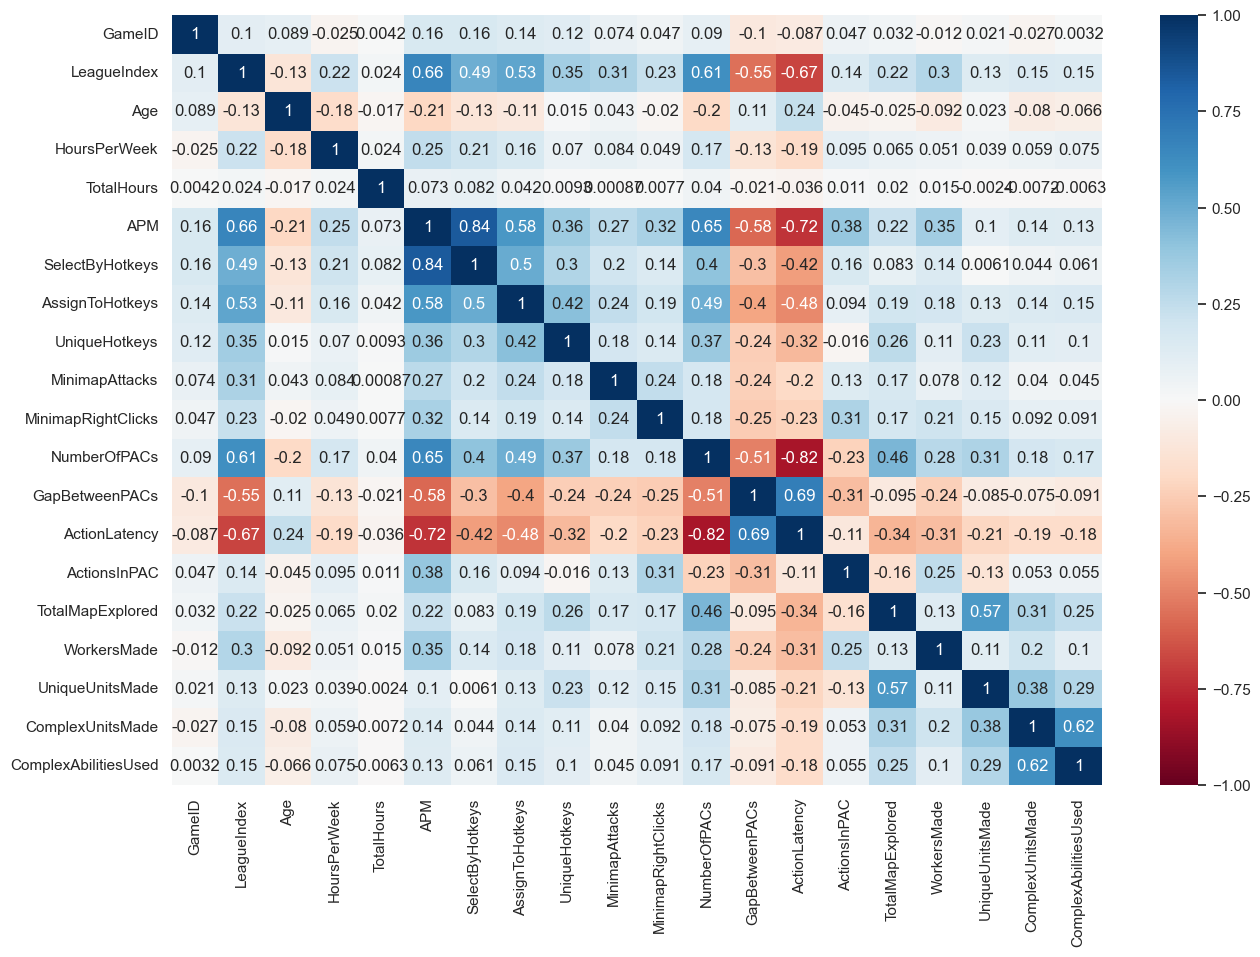

In [856]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), vmax=1, vmin=-1, cmap='RdBu', annot=True)
plt.show()

I see this problem as a Multi-Classification Problem where LeagueIndex will be the Target variable. Let us make a new correlation matrix by dropping target variables and insignificant variables

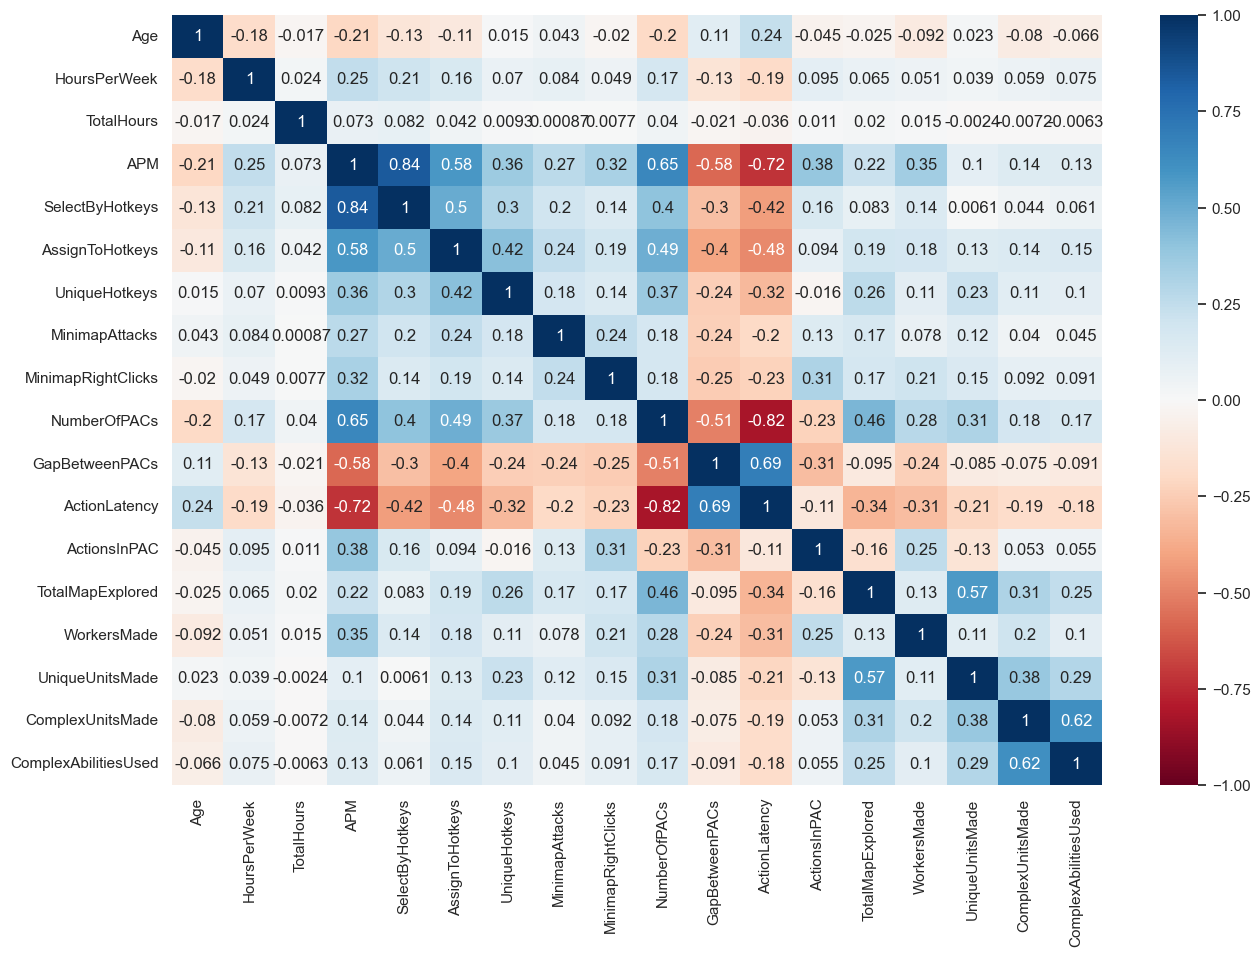

In [857]:
df_corr = df.drop(columns=['GameID','LeagueIndex'])
plt.figure(figsize=(15,10))
sns.heatmap(df_corr.corr(), vmax=1, vmin=-1, cmap='RdBu', annot=True)
plt.show()

Looking at the Correlation matrix, it is quite obvious that APM will play a very high role in determing League Rankings. I'm a little concerned about Action Latency and SelectByHotKeys as they have high correlation avlues with APM.

It's quite obvious that a player with high APM wil have a low Action Latency. On the other hand, number of units/building selections per timestamp cannot be determined by APM, as APM can be any action in the game.

Hence, I have decided to only drop ActionLatency

In [858]:
df.drop(columns=['ActionLatency'], inplace=True)

In [859]:
# Checking discrepancy in League Index 8
df[df['LeagueIndex']==8].describe().T

,count,mean,std,min,25%,50%,75%,max
GameID,55.0,10051.509091,25.894281,10001.0,10028.5,10052.0,10072.5,10095.0
LeagueIndex,55.0,8.0,0.0,8.0,8.0,8.0,8.0,8.0
Age,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
HoursPerWeek,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
TotalHours,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
APM,55.0,267.341236,56.183006,146.3892,222.2286,274.3404,313.2783,375.8664
SelectByHotkeys,55.0,0.020981,0.009299,0.004582,0.014308,0.019817,0.028263,0.042576
AssignToHotkeys,55.0,0.000937,0.000349,0.000266,0.000683,0.000874,0.001158,0.001752
UniqueHotkeys,55.0,7.345455,2.110101,4.0,6.0,7.0,10.0,10.0
MinimapAttacks,55.0,0.000376,0.000295,0.0,0.000173,0.00035,0.000498,0.001242


In [860]:
df[df['LeagueIndex']==8].shape

(55, 19)

Seems all the missing values in Age, HoursPerWeek and TotalHours are in League Index 8. Since these variables are not very imporant, I will ignore imputing missing values

# Exploratory Data Analysis

Now that we are clear that we need to predict the League Index, let us use that as the target variable.

**Distribution of LeagueIndex**

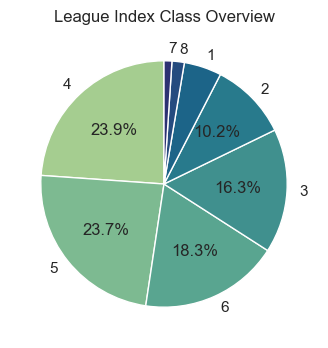

In [861]:
league_counts = df['LeagueIndex'].value_counts()
threshold = 5

# Create a gradient of colors
num_colors = len(league_counts)
colors = plt.cm.get_cmap('crest', num_colors)

# Create a pie chart
fig, ax = plt.subplots(figsize=(6, 4))
wedges, labels, autopct = ax.pie(league_counts.values, labels=league_counts.index, autopct='', startangle=90, colors=colors(np.arange(num_colors)))

# Set the title and aspect ratio of the chart
ax.set_title('League Index Class Overview')
ax.set_aspect('equal')

# Set the percentage values only for slices larger than the threshold
for i, wedge in enumerate(wedges):
    if league_counts.values[i] / sum(league_counts) * 100 > threshold:
        autopct[i].set_text(f'{league_counts.values[i] / sum(league_counts) * 100:.1f}%')
plt.show()

### This is a class imbalance problem
- I will solve this problem by using a Balanced Log Loss function to deal with Class Imbalance when modelling
- I will also be creating a new dataset using SMOTE oversampling to balance the classes

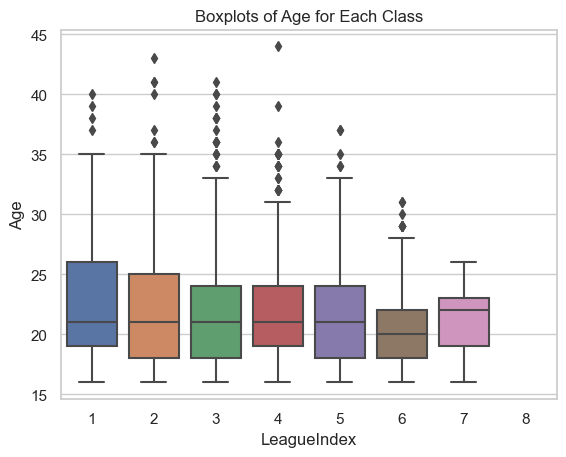

In [862]:
# Age Variable
sns.set(style="whitegrid")

sns.boxplot(data=df, x="LeagueIndex", y="Age")

plt.title("Boxplots of Age for Each Class")
plt.xlabel("LeagueIndex")
plt.ylabel("Age")
plt.show()

On an average, players are between the age of 19-25 though there are a lot of players with age above 30-35

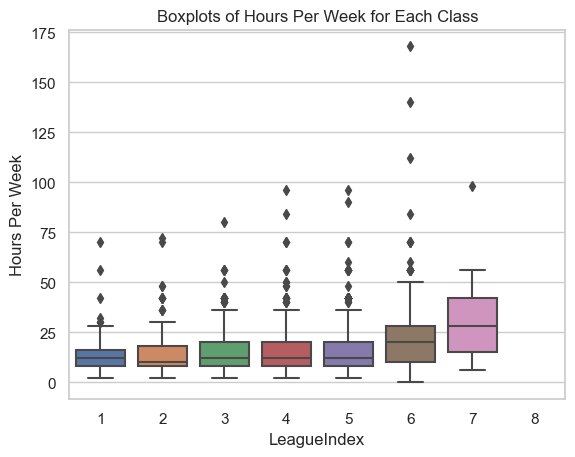

In [863]:
# Hours Per Week Variable
sns.set(style="whitegrid")

sns.boxplot(data=df, x="LeagueIndex", y="HoursPerWeek")

plt.title("Boxplots of Hours Per Week for Each Class")
plt.xlabel("LeagueIndex")
plt.ylabel("Hours Per Week")
plt.show()

On an average, players are generally spending 10-15 hours per week. What I notice is a slight increase in Hours Per Week for League 6 and League 7, which makes sense.

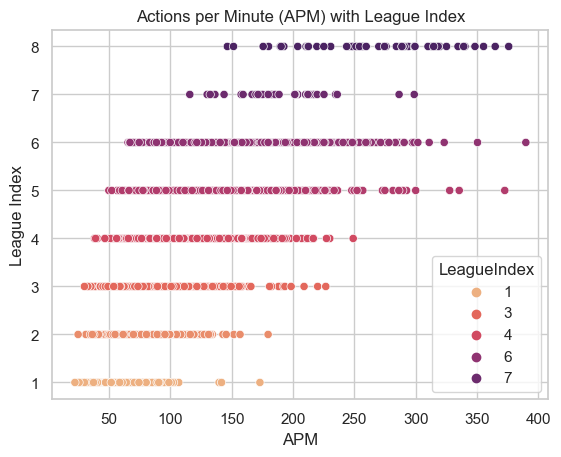

In [864]:
sns.set(style="whitegrid")

sns.scatterplot(data=df, x="APM", y="LeagueIndex", hue="LeagueIndex", palette='flare')

plt.title("Actions per Minute (APM) with League Index")
plt.xlabel("APM")
plt.ylabel("League Index")

# Show the plot
plt.show()

We can see a clear relation between APM and different League Indexes, as there is an increase in APM as the League Level of the player increases. APM should act as a very good predicting variable to make class predictions

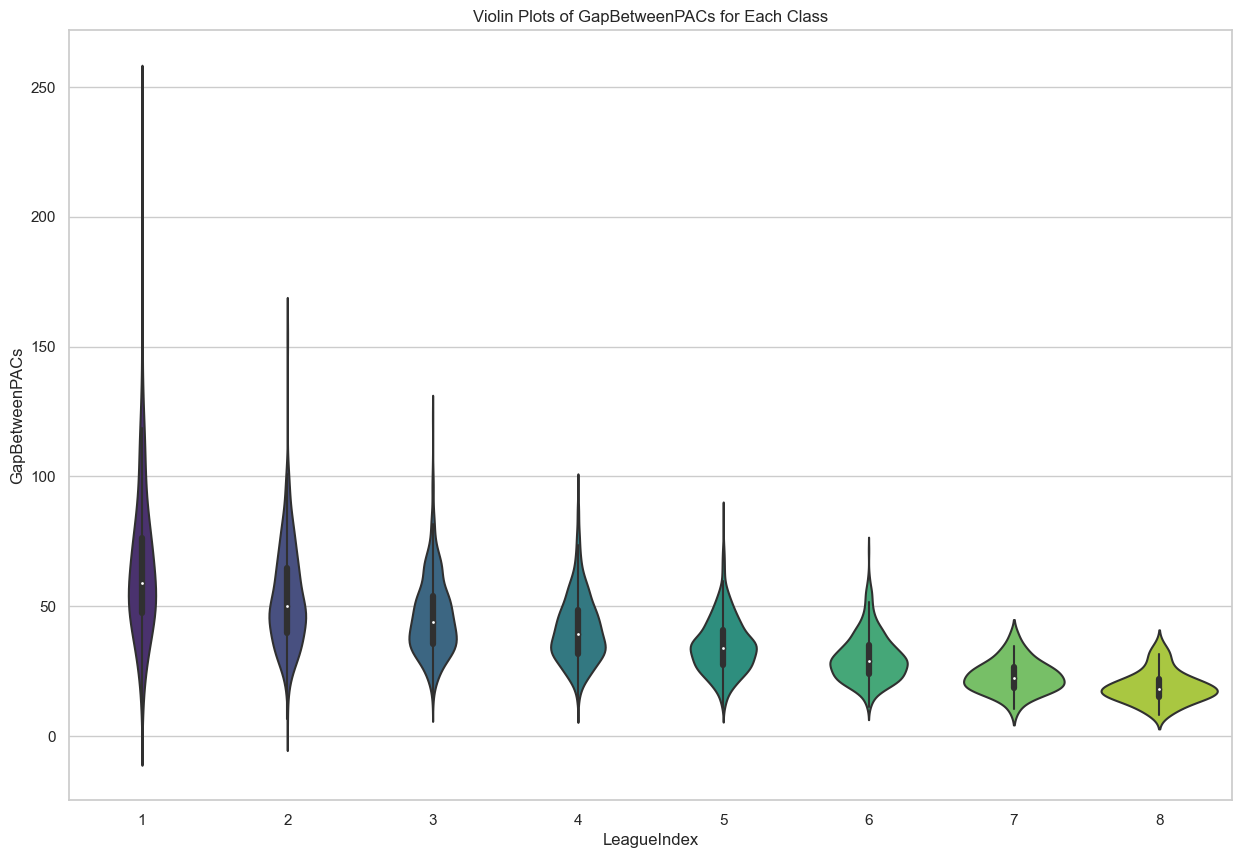

In [865]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,10))
sns.violinplot(data=df, x="LeagueIndex", y="GapBetweenPACs", palette='viridis')

# Set the title and labels
plt.title("Violin Plots of GapBetweenPACs for Each Class")
plt.xlabel("LeagueIndex")
plt.ylabel("GapBetweenPACs")

# Show the plot
plt.show()

It is quite noticeable that Gap Between PACs is steeply decreasing as the League Index of players is increasing. Also League Index 1 Players have a very high variation in Gap Between PACs, displaying ameateur players as well

# SMOTE Oversampling

First step would be data imputation

In [866]:
df_smote = df.copy()

In [867]:
summary(df_smote)

data shape: (3395, 19)


,data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
GameID,int64,0,0.000000,3395,52.0,10095.0,2464.5,4874.0,7108.5
LeagueIndex,int64,0,0.000000,8,1.0,8.0,3.0,4.0,5.0
Age,Int64,55,1.620029,28,16.0,44.0,19.0,21.0,24.0
HoursPerWeek,Int64,56,1.649485,32,0.0,168.0,8.0,12.0,20.0
TotalHours,Int64,57,1.678940,237,3.0,1000000.0,300.0,500.0,800.0
APM,float64,0,0.000000,3374,22.0596,389.8314,79.9002,108.0102,142.7904
SelectByHotkeys,float64,0,0.000000,3375,0.0,0.043088,0.001258,0.0025,0.005133
AssignToHotkeys,float64,0,0.000000,3361,0.0,0.001752,0.000204,0.000353,0.000499
UniqueHotkeys,int64,0,0.000000,11,0.0,10.0,3.0,4.0,6.0
MinimapAttacks,float64,0,0.000000,2471,0.0,0.003019,0.0,0.00004,0.000119


### Analyzing the Missing Data

In [868]:
df_missing = df_smote[df_smote.isnull().any(axis=1)]
df_missing.groupby('LeagueIndex').head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,1064,5,17,20,<NA>,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,3.0972,31,0.000763,7,0.000106,0.000116
1841,5255,5,18,<NA>,<NA>,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,5.3822,23,0.001055,5,0.000000,0.000338
3340,10001,8,<NA>,<NA>,<NA>,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,<NA>,<NA>,<NA>,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,<NA>,<NA>,<NA>,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,<NA>,<NA>,<NA>,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,<NA>,<NA>,<NA>,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,5.2811,28,0.000739,6,0.000000,0.000000


There are 2 missing value rows in League Index 5, and all the rows of league Index 8 have missing values

**Let us fix rows of League Index 5**
- Row 358 has TotalHours missing
- Row 1841 has HoursPerWeek and TotalHours missing

In [869]:
k = df_smote[(df_smote['LeagueIndex']==5) & (df_smote['HoursPerWeek']==20) & (df_smote['Age']==17)]
k

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,1064,5,17,20,<NA>,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,3.0972,31,0.000763,7,0.000106,0.000116
848,2464,5,17,20,700,122.4510,0.004076,0.000686,5,0.000000,0.000381,0.004901,34.8468,3.9197,27,0.001270,8,0.000241,0.000381
1018,2943,5,17,20,750,117.6066,0.002757,0.000543,2,0.000081,0.001087,0.002866,25.7333,7.3270,24,0.001263,6,0.000272,0.000149
1223,3535,5,17,20,450,176.7930,0.007109,0.000616,4,0.000015,0.000150,0.004239,21.1388,6.5142,22,0.000676,4,0.000000,0.000000
1466,4217,5,17,20,700,100.3008,0.002818,0.000224,1,0.000000,0.000548,0.003277,63.5890,4.3140,20,0.001745,6,0.000045,0.000034
1471,4238,5,17,20,730,102.8352,0.001832,0.000156,5,0.000045,0.000235,0.004620,36.3390,3.7739,29,0.000374,8,0.000061,0.000274
1866,5331,5,17,20,400,108.5178,0.001724,0.000348,8,0.000093,0.000788,0.004105,30.2566,4.6497,43,0.000796,11,0.000039,0.000363
2011,5681,5,17,20,900,184.5996,0.011198,0.000622,4,0.000086,0.000193,0.003389,20.6115,6.9684,11,0.000944,4,0.000000,0.000386
2206,6215,5,17,20,500,119.6562,0.001361,0.000164,4,0.000009,0.001206,0.002787,32.2632,7.7770,33,0.001160,8,0.000000,0.000000
2227,6271,5,17,20,1700,194.7306,0.015975,0.000466,5,0.000162,0.000162,0.003791,15.5054,5.4492,13,0.000831,7,0.000000,0.000101


I see a direct relation between APM and TotalHours for a dataset with League Index 5, Hours per week 20, and Age 17. I am gonna impute the value 650 for row 358

In [870]:
df_smote.loc[358, 'TotalHours'] = np.int64(650)

In [871]:
k = df_smote[(df_smote['LeagueIndex']==5) & (df_smote['Age']==18)][['TotalHours','HoursPerWeek']]
k.describe().T

,count,mean,std,min,25%,50%,75%,max
TotalHours,80.0,13206.075,111724.094046,120.0,461.25,700.0,862.5,1000000.0
HoursPerWeek,80.0,20.55,11.910957,2.0,10.0,22.0,28.0,56.0


I am gonna impute the median for Row 1841

In [872]:
df_smote.loc[1841, 'TotalHours'] = df_smote['TotalHours'].median()
df_smote.loc[1841, 'HoursPerWeek'] = df_smote['HoursPerWeek'].median()

League index 8 has all row values for Age, Hours Per Week and Total Hours missing. I am gonna drop League Index 8 for this case

In [873]:
df_smote = df_smote.dropna()

In [874]:
df_smote[df_smote.isnull().any(axis=1)]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed


# Data Preprocessing

I am going to use a Robust Scaler to different dimensions of variables.

In [875]:
df.columns

Index(['GameID', 'LeagueIndex', 'Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionsInPAC',
       'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed'],
      dtype='object')

I will be creating a function that does Preprocessing on the Data. The steps are-
- Define the columns to be scaled.
- Create a copy of the input DataFrame.
- Encode the 'LeagueIndex' column using LabelEncoder (Converting 1-8 to 0-7)
- Scale the specified columns using RobustScaler.
- Concatenate the scaled data with the remaining columns.
- Return the preprocessed DataFrame

In [876]:
def Preprocessing(input_df: pd.DataFrame)->pd.DataFrame:
    columns_to_scale = ['Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionsInPAC',
       'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed']
    
    data_scaled = input_df[columns_to_scale].copy()
    label_encoder = LabelEncoder()
    input_df['LeagueIndex'] = label_encoder.fit_transform(input_df['LeagueIndex'])
    
    rc = RobustScaler()
    data_scaled = rc.fit_transform(data_scaled) #added scaling
    data_scaled = pd.DataFrame(data_scaled, columns=columns_to_scale)
    data_scaled = pd.concat([data_scaled, input_df.drop(columns=columns_to_scale)], axis=1)
    return data_scaled

df = Preprocessing(df)
df_smote = Preprocessing(df_smote)

In [877]:
df_smote.head()

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,GameID,LeagueIndex
0,1.2,-0.166667,5.0,0.602000,0.288570,-0.443897,1.000000,0.629531,0.309396,1.168377,-0.228890,-0.190434,0.6,0.854357,0.000000,0.0,-0.112384,52,4
1,0.4,-0.166667,9.0,0.364046,0.231463,-0.307306,0.000000,2.257226,0.418290,0.738395,-0.215770,-0.137991,0.0,0.501939,-0.333333,0.0,1.025438,55,4
2,1.8,-0.166667,-0.6,-0.609579,-0.363726,-0.045871,0.000000,2.253405,0.496931,-0.357488,0.395554,-0.591295,0.0,-0.277076,0.000000,0.0,0.922328,56,3
3,-0.4,0.666667,-0.2,0.008727,-0.381978,-0.466554,-1.000000,0.129638,0.719498,0.322265,-0.408585,-0.097157,-0.3,-0.829474,0.333333,0.0,1.990259,57,2
4,2.2,-0.166667,0.0,0.259878,-0.354289,-0.074192,-0.666667,-0.341113,2.850593,-0.799754,-0.749053,2.427904,-0.7,0.468970,-0.666667,0.0,-0.006841,58,2


### Now that data has been imputed, I will use SMOTE oversampling

In [878]:
def dfSmote(df_smote):
    X = df_smote.drop(['LeagueIndex'], axis=1)
    y = df_smote['LeagueIndex']
    
    smote = SMOTE()
    X_s, y_s = smote.fit_resample(X, y)
    
    df_smote = pd.concat([X_s, y_s], axis=1)
    
    return df_smote


In [879]:
X = df_smote.drop(['LeagueIndex'], axis=1)
y = df_smote['LeagueIndex']

In [880]:
smote = SMOTE()
X_s, y_s = smote.fit_resample(X, y)

In [881]:
df_smote = pd.concat([X_s, y_s], axis=1)

In [882]:
print(df.shape)
print(df_smote.shape)

(3395, 19)
(5677, 19)


# Feature Selection

I will run a simple XG Boost model to find feature importance

In [883]:
X = df.drop(columns=['GameID', 'LeagueIndex'])
y = df['LeagueIndex']

In [884]:
model = xgb.XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [888]:
feature_importance = pd.DataFrame(
    {'Feature': X.columns, 'Importance': model.feature_importances_}
)
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

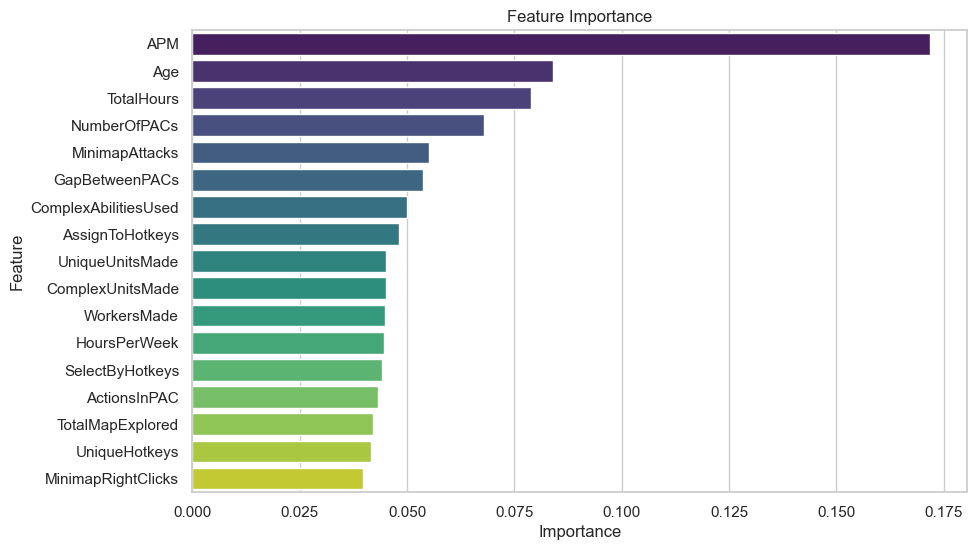

In [889]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

**As I predicted earlier, APM holds the highest importance**

Since the values are very close, I won't be dropping any feature

# ETL (Extract, Transform, Load) Pipeline

I will be developing 2 seperate ETL pieplines, one for original dataset, and one for SMOTE oversampled dataset

### ETL Pipeline for Original Dataset

In [890]:
def etl_pipeline_orig(df):
    #Convert object type to Int type
    convertObjToInt(df)
    
    # Dropping Action Latency Column
    df.drop(columns=['ActionLatency'], inplace=True)
    
    # Preprocessing the data
    df = Preprocessing(df)
    
    return df

### ETL Pipeline for SMOTE oversampled dataset

In [891]:
def etl_pipeline_smote(df):
    #Convert object type to Int type
    convertObjToInt(df)
    
    # Dropping Action Latency Column
    df.drop(columns=['ActionLatency'], inplace=True)
    
    # Data Imputation
    df.loc[358, 'TotalHours'] = np.int64(650)
    df.loc[1841, 'TotalHours'] = df['TotalHours'].median()
    df.loc[1841, 'HoursPerWeek'] = df['HoursPerWeek'].median()
    df = df.dropna()
    
    # Preprocessing the data
    df = Preprocessing(df)
    
    # Using SMOTE
    df = dfSmote(df)

    return df

# Evaluation Metric

**Due to class imbalance problem, I will be using Balanced Log Loss Function**

$$Balanced \, Log \, Loss = -\frac{\sum_{i=1}^{8}[w_{i}\sum_{k=1}^{N_{m}}y_{ik}log(p_{ik})]}{\sum_{i=1}^{8}w_{i}}$$
$$where \, w_{i} = \frac{1}{\frac{Size \, of \, target \, class \, i}{Size \, of \, target}}$$

In [892]:
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    weights = 1 / (nc / y_true.shape[0])
    
    balanced_log_loss_score = 0
    for i in range(len(nc)):
        class_mask = (y_true == i)
        class_log_loss = -(np.dot(np.where(class_mask,1,0), np.log(y_pred[:,i])))
        class_weighted_loss = (weights[i]/nc[i]) * class_log_loss
        balanced_log_loss_score += class_weighted_loss

    balanced_log_loss_score /= np.sum(weights)

    return balanced_log_loss_score

# Modelling

Now that we have processed data, we can use various models, conduct hyperparameter tuning and find the best performing model.

**Objective:** Multi-class classification (League Index 1 to 8)

**Evaluation Function:** Balanced Log Loss

### Class CFG has the necessary parameters to train the models

In [895]:
class CFG:
    VER = 1
    seed = 3407 #52
    DATA_PATH = Path('C:/Users/shaur/Downloads/EG Assessment')
    OOF_DATA_PATH = Path('./oof')
    MODEL_DATA_PATH = Path('./models')
    n_folds = 10 #replaced 20
    target_col = 'LeagueIndex'
    metric = 'balanced_log_loss'
    metric_maximize_flag = False
    num_boost_round = 50500
    early_stopping_round = 500
    verbose = 2000
    boosting_type = 'dart'
    lgb_params = {
        'objective': 'multiclass', # 'binary', 'multiclass'
        'metric': None, # 'auc', 'multi_logloss'
        'num_class': 8,
        'boosting': boosting_type,
        'device_type':'cpu',
        'learning_rate': 0.005,
        'num_leaves': 5,
        'feature_fraction': 0.50,
        'bagging_fraction': 0.80,
        'lambda_l1': 2, 
        'lambda_l2': 4,
        'n_jobs': -1,
        'is_unbalance':True, #added balancing
        'verbose': -1, #added silence
        # 'min_data_in_leaf': 40,
        # 'bagging_freq': 10,
        'seed': seed,
    }
    xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 8,
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,  # Adjust the learning rate
    'max_depth': 3,  # Decrease the max_depth
    'colsample_bytree': 0.8,  # Increase the colsample_bytree
    'subsample': 0.8,  # Increase the subsample
    'gamma': 0.5,  # Adjust the gamma
    'reg_alpha': 0.1,  # Add L1 regularization
    'reg_lambda': 0.1,  # Add L2 regularization
    'random_state': seed
}


## LightGBM and XGBoost Ensemble Model

In [900]:
def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
  
    train_weights = 1 / (np.bincount(y_train) / len(y_train))
    valid_weights = 1 / (np.bincount(y_valid) / len(y_valid))

    lgb_train = lgb.Dataset(x_train, y_train, weight=train_weights[y_train])
    lgb_valid = lgb.Dataset(x_valid, y_valid, weight=valid_weights[y_valid])
    
    model = lgb.train(
                params = CFG.lgb_params,
                train_set = lgb_train,
                num_boost_round = CFG.num_boost_round,
                valid_sets = [lgb_train, lgb_valid],
                early_stopping_rounds = CFG.early_stopping_round,
                verbose_eval = CFG.verbose,
                # feval = lgb_metric,
            )
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred

In [901]:
def xgboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
    train_weights = 1 / (np.bincount(y_train) / len(y_train))
    valid_weights = 1 / (np.bincount(y_valid) / len(y_valid))

    xgb_train = xgb.DMatrix(data=x_train, label=y_train, weight=train_weights[y_train])
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid, weight=valid_weights[y_valid])
    
    model = xgb.train(
                CFG.xgb_params, 
                dtrain = xgb_train, 
                num_boost_round = CFG.num_boost_round, 
                evals = [(xgb_train, 'train'), (xgb_valid, 'eval')], 
                early_stopping_rounds = CFG.early_stopping_round, 
                verbose_eval = CFG.verbose,
                # feval = xgb_metric, 
                # maximize = CFG.metric_maximize_flag, 
            )
    # Predict validation
    valid_pred = model.predict(xgb.DMatrix(x_valid), iteration_range=(0, model.best_ntree_limit))
    return model, valid_pred

In [902]:
def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros((len(train_df),8))
    oof_fold = np.zeros(len(train_df))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (train_index, valid_index) in enumerate(kfold.split(train_df, train_df[CFG.target_col])):
        print('-'*50)
        print(f'{method} training fold {fold + 1}')
        
        x_train = train_df[features].iloc[train_index]
        y_train = train_df[CFG.target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[CFG.target_col].iloc[valid_index]
        if method == 'lightgbm':
            model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features)
        if method == 'xgboost':
            model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features)
            
        # Save best model
        pickle.dump(model, open(CFG.MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred
        oof_fold[valid_index] = fold + 1
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()

    # Compute out of folds metric
    score = balanced_log_loss(train_df[CFG.target_col], oof_predictions)
    print(f'{method} our out of folds CV score is {score}')

In [903]:
features= ['Age', 'HoursPerWeek', 'TotalHours', 'APM',
       'SelectByHotkeys', 'AssignToHotkeys', 'UniqueHotkeys', 'MinimapAttacks',
       'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 'ActionsInPAC',
       'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade',
       'ComplexUnitsMade', 'ComplexAbilitiesUsed']

## Evaluation for Gradient Boosted Models

In [798]:
def lightgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros((len(x_test), 8))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds

In [799]:
def xgboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros((len(x_test), 8))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict(xgb.DMatrix(x_test), iteration_range=(0, model.best_ntree_limit))
    return test_pred / CFG.n_folds

In [800]:
def gradient_boosting_model_inference(method: str, test_df: pd.DataFrame, features: list):
    x_test = test_df[features]
    if method == 'lightgbm':
        test_pred = lightgbm_inference(x_test)
    if method == 'xgboost':
        test_pred = xgboost_inference(x_test)
    return test_pred

# Evaluation Functions

## Confusion Matrix, Multi-class ROC-AUC

In [912]:
def classification_report_df(y_true, y_pred):
    classes = np.unique(y_true)
    true = label_binarize(y_true, classes=classes)
    pred = label_binarize(y_pred, classes=classes)
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i, c in enumerate(classes):
        fpr[c], tpr[c], _ = roc_curve(true[:, i], pred[:, i])
        roc_auc[c] = auc(fpr[c], tpr[c])
        
    fpr["micro"], tpr["micro"], _ = roc_curve(true.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

In [913]:
def plot_multiclass_roc(y_true, y_pred, plot_title):
    fpr, tpr, roc_auc = classification_report_df(y_true, y_pred)
    classes = fpr.keys()
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in classes:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= len(classes)
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for c, color in zip(classes, colors):
        plt.plot(fpr[c], tpr[c], color=color, lw=lw,
                 label=f'ROC curve of class {c} (area = {roc_auc[c]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(plot_title)
    plt.legend(loc="lower right")
    plt.show()

In [984]:
def cm_plot(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

    # Set plot labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Show plot
    plt.show()

In [980]:
def evaluation(y_true, y_pred, plot_title):
    print(classification_report(y_true, y_pred))
    cm_plot(y_true, y_pred)
    plot_multiclass_roc(y_true, y_pred, plot_title)

## Training on SMOTE oversampled data

In [904]:
X = df_smote.drop(['LeagueIndex'], axis=1)
y = df_smote['LeagueIndex']

In [905]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

train_df_smote = pd.concat([X_train, y_train], axis=1)
test_df_smote = pd.concat([X_test, y_test], axis=1)

In [906]:
train_df.shape

(5109, 19)

In [672]:
methods = ['lightgbm', 'xgboost']
for method in methods:
    gradient_boosting_model_cv_training(method, train_df, features)

--------------------------------------------------
lightgbm training fold 1
[2000]	training's multi_logloss: 1.12765	valid_1's multi_logloss: 1.22205
[4000]	training's multi_logloss: 0.960064	valid_1's multi_logloss: 1.10604
[6000]	training's multi_logloss: 0.859652	valid_1's multi_logloss: 1.06261
[8000]	training's multi_logloss: 0.776729	valid_1's multi_logloss: 1.03365
[10000]	training's multi_logloss: 0.71389	valid_1's multi_logloss: 1.01451
[12000]	training's multi_logloss: 0.653522	valid_1's multi_logloss: 0.99966
[14000]	training's multi_logloss: 0.604089	valid_1's multi_logloss: 0.987879
[16000]	training's multi_logloss: 0.556859	valid_1's multi_logloss: 0.979399
[18000]	training's multi_logloss: 0.518277	valid_1's multi_logloss: 0.974635
[20000]	training's multi_logloss: 0.48395	valid_1's multi_logloss: 0.970842
[22000]	training's multi_logloss: 0.451694	valid_1's multi_logloss: 0.967886
[24000]	training's multi_logloss: 0.422447	valid_1's multi_logloss: 0.966076
[26000]	train

[8000]	training's multi_logloss: 0.784204	valid_1's multi_logloss: 1.01119
[10000]	training's multi_logloss: 0.721162	valid_1's multi_logloss: 0.988959
[12000]	training's multi_logloss: 0.660712	valid_1's multi_logloss: 0.97108
[14000]	training's multi_logloss: 0.611838	valid_1's multi_logloss: 0.959498
[16000]	training's multi_logloss: 0.564078	valid_1's multi_logloss: 0.948743
[18000]	training's multi_logloss: 0.524869	valid_1's multi_logloss: 0.939909
[20000]	training's multi_logloss: 0.490425	valid_1's multi_logloss: 0.934526
[22000]	training's multi_logloss: 0.457699	valid_1's multi_logloss: 0.929601
[24000]	training's multi_logloss: 0.42827	valid_1's multi_logloss: 0.927068
[26000]	training's multi_logloss: 0.399704	valid_1's multi_logloss: 0.924559
[28000]	training's multi_logloss: 0.375276	valid_1's multi_logloss: 0.923669
[30000]	training's multi_logloss: 0.354563	valid_1's multi_logloss: 0.922663
[32000]	training's multi_logloss: 0.333019	valid_1's multi_logloss: 0.921021
[34

[16000]	training's multi_logloss: 0.55869	valid_1's multi_logloss: 0.990651
[18000]	training's multi_logloss: 0.519606	valid_1's multi_logloss: 0.985776
[20000]	training's multi_logloss: 0.485249	valid_1's multi_logloss: 0.982092
[22000]	training's multi_logloss: 0.453145	valid_1's multi_logloss: 0.979624
[24000]	training's multi_logloss: 0.424282	valid_1's multi_logloss: 0.976095
[26000]	training's multi_logloss: 0.396372	valid_1's multi_logloss: 0.974513
[28000]	training's multi_logloss: 0.37211	valid_1's multi_logloss: 0.972069
[30000]	training's multi_logloss: 0.350879	valid_1's multi_logloss: 0.970217
[32000]	training's multi_logloss: 0.329392	valid_1's multi_logloss: 0.969445
[34000]	training's multi_logloss: 0.309114	valid_1's multi_logloss: 0.96973
[36000]	training's multi_logloss: 0.290967	valid_1's multi_logloss: 0.971832
[38000]	training's multi_logloss: 0.27348	valid_1's multi_logloss: 0.97315
[40000]	training's multi_logloss: 0.25686	valid_1's multi_logloss: 0.97514
[42000

## Validation of SMOTE Oversampled Data

In [801]:
results_lgb = gradient_boosting_model_inference('lightgbm', test_df, features)
results_xgb = gradient_boosting_model_inference('xgboost', test_df, features)

In [804]:
test_df.reset_index(drop=True, inplace=True)

In [805]:
k_lgb = pd.DataFrame(results_lgb)
k_lgb = pd.concat([test_df[['LeagueIndex']], k_lgb],axis=1)

In [179]:
k_xgb = pd.DataFrame(results_xgb)
k_xgb = pd.concat([test_df[['LeagueIndex']], k_xgb],axis=1)

In [806]:
k_lgb['highest_prob_class'] = k_lgb.iloc[:, 1:].idxmax(axis=1)
k_xgb['highest_prob_class'] = k_xgb.iloc[:, 1:].idxmax(axis=1)

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        81
           1       0.73      0.57      0.64        81
           2       0.48      0.38      0.42        81
           3       0.38      0.33      0.35        81
           4       0.42      0.33      0.37        81
           5       0.59      0.60      0.60        81
           6       0.99      1.00      0.99        82
           7       0.00      0.00      0.00         0

    accuracy                           0.59       568
   macro avg       0.55      0.52      0.53       568
weighted avg       0.63      0.59      0.60       568



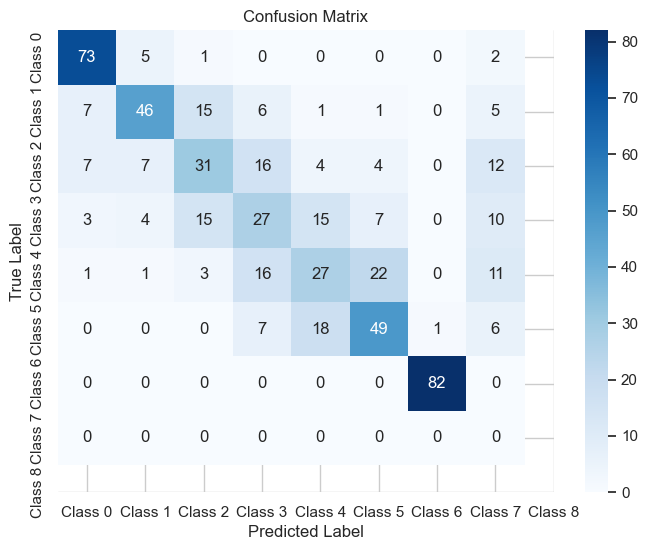

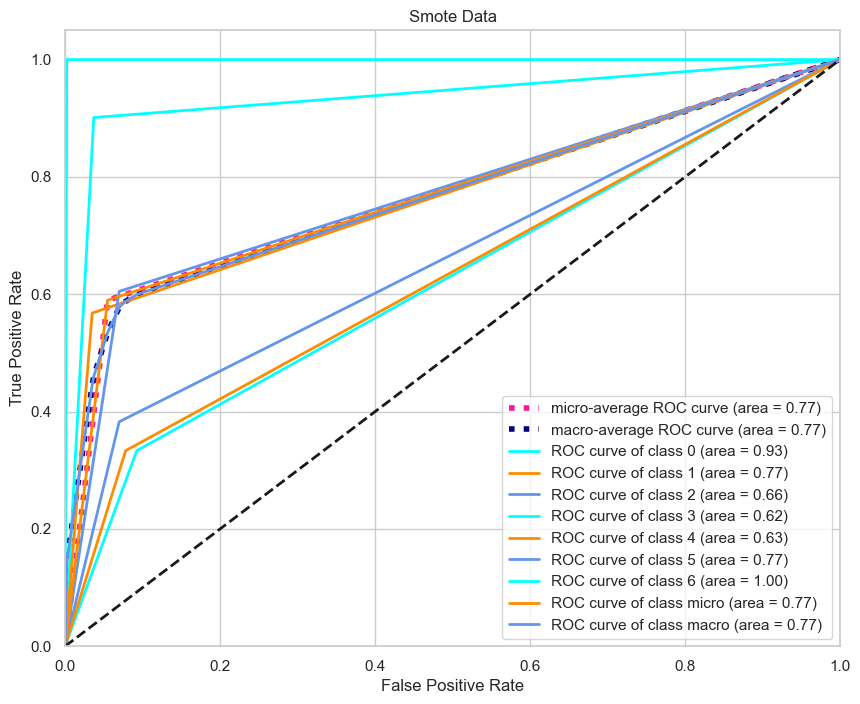

In [926]:
evaluation(k_lgb['LeagueIndex'],k_lgb['highest_prob_class'], "Smote Data")

              precision    recall  f1-score   support

           0       0.30      0.47      0.36        17
           1       0.24      0.31      0.27        35
           2       0.31      0.40      0.35        55
           3       0.44      0.20      0.27        81
           4       0.43      0.37      0.40        81
           5       0.54      0.73      0.62        62
           6       0.50      0.33      0.40         3
           7       1.00      1.00      1.00         6

    accuracy                           0.41       340
   macro avg       0.47      0.48      0.46       340
weighted avg       0.42      0.41      0.40       340



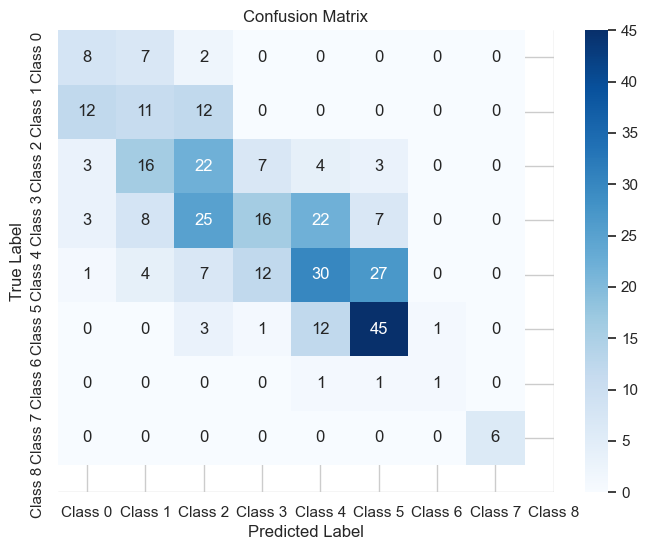

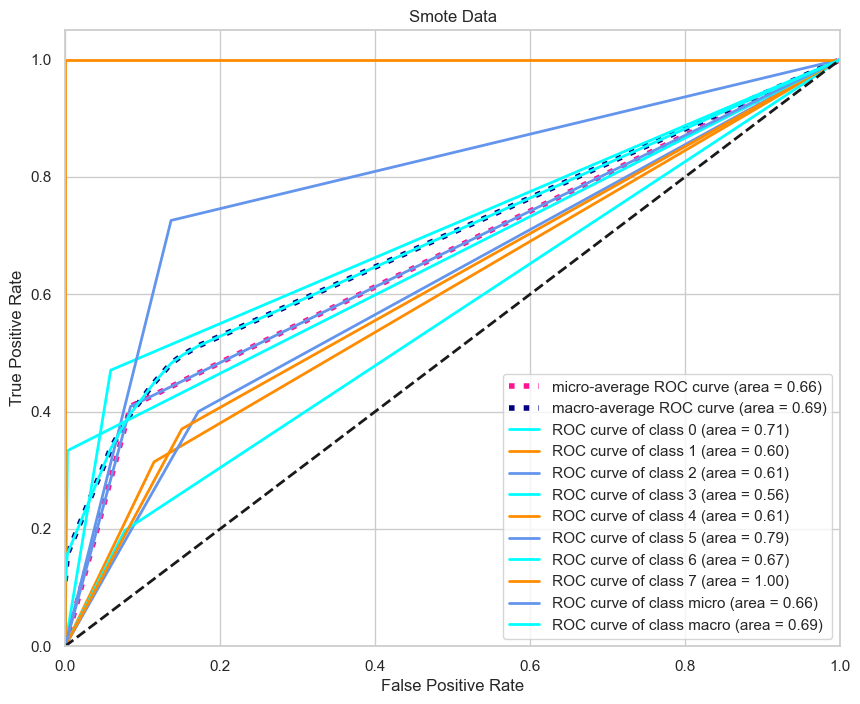

In [1034]:
evaluation(k_xgb['LeagueIndex'],k_xgb['highest_prob_class'], "Smote Data")

### Training on original data

In [929]:
X = df.drop(['LeagueIndex'], axis=1)
y = df['LeagueIndex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [930]:
train_df.shape

(3055, 19)

In [ ]:
def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros((len(train_df),8))
    oof_fold = np.zeros(len(train_df))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (train_index, valid_index) in enumerate(kfold.split(train_df, train_df[CFG.target_col])):
        print('-'*50)
        print(f'{method} training fold {fold + 1}')
        
        x_train = train_df[features].iloc[train_index]
        y_train = train_df[CFG.target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[CFG.target_col].iloc[valid_index]
        if method == 'lightgbm':
            model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features)
        if method == 'xgboost':
            model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features)
            
        # Save best model
        pickle.dump(model, open(CFG.MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}_ns.pkl', 'wb'))
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred
        oof_fold[valid_index] = fold + 1
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()

    # Compute out of folds metric
    score = balanced_log_loss(train_df[CFG.target_col], oof_predictions)
    print(f'{method} our out of folds CV score is {score}')

In [682]:
methods = ['lightgbm', 'xgboost']
for method in methods:
    gradient_boosting_model_cv_training(method, train_df, features)

--------------------------------------------------
lightgbm training fold 1
[2000]	training's multi_logloss: 1.00561	valid_1's multi_logloss: 1.13471
[4000]	training's multi_logloss: 0.840876	valid_1's multi_logloss: 1.10337
[6000]	training's multi_logloss: 0.74602	valid_1's multi_logloss: 1.14165
[8000]	training's multi_logloss: 0.670152	valid_1's multi_logloss: 1.18055
[10000]	training's multi_logloss: 0.613052	valid_1's multi_logloss: 1.21743
[12000]	training's multi_logloss: 0.55896	valid_1's multi_logloss: 1.27615
[14000]	training's multi_logloss: 0.515897	valid_1's multi_logloss: 1.31895
[16000]	training's multi_logloss: 0.474563	valid_1's multi_logloss: 1.36183
[18000]	training's multi_logloss: 0.440538	valid_1's multi_logloss: 1.38682
[20000]	training's multi_logloss: 0.410705	valid_1's multi_logloss: 1.40863
[22000]	training's multi_logloss: 0.382421	valid_1's multi_logloss: 1.43
[24000]	training's multi_logloss: 0.35779	valid_1's multi_logloss: 1.45322
[26000]	training's mult

[10000]	training's multi_logloss: 0.610308	valid_1's multi_logloss: 1.32352
[12000]	training's multi_logloss: 0.555977	valid_1's multi_logloss: 1.3562
[14000]	training's multi_logloss: 0.513092	valid_1's multi_logloss: 1.37893
[16000]	training's multi_logloss: 0.471967	valid_1's multi_logloss: 1.40043
[18000]	training's multi_logloss: 0.438923	valid_1's multi_logloss: 1.41542
[20000]	training's multi_logloss: 0.409731	valid_1's multi_logloss: 1.42126
[22000]	training's multi_logloss: 0.382334	valid_1's multi_logloss: 1.43191
[24000]	training's multi_logloss: 0.357515	valid_1's multi_logloss: 1.43602
[26000]	training's multi_logloss: 0.333284	valid_1's multi_logloss: 1.44152
[28000]	training's multi_logloss: 0.312242	valid_1's multi_logloss: 1.45657
[30000]	training's multi_logloss: 0.294413	valid_1's multi_logloss: 1.46643
[32000]	training's multi_logloss: 0.276543	valid_1's multi_logloss: 1.48208
[34000]	training's multi_logloss: 0.259814	valid_1's multi_logloss: 1.49198
[36000]	train

[20000]	training's multi_logloss: 0.403934	valid_1's multi_logloss: 1.82315
[22000]	training's multi_logloss: 0.375455	valid_1's multi_logloss: 1.84304
[24000]	training's multi_logloss: 0.350228	valid_1's multi_logloss: 1.85837
[26000]	training's multi_logloss: 0.325416	valid_1's multi_logloss: 1.87003
[28000]	training's multi_logloss: 0.304318	valid_1's multi_logloss: 1.87208
[30000]	training's multi_logloss: 0.286552	valid_1's multi_logloss: 1.87829
[32000]	training's multi_logloss: 0.268823	valid_1's multi_logloss: 1.88735
[34000]	training's multi_logloss: 0.252293	valid_1's multi_logloss: 1.90193
[36000]	training's multi_logloss: 0.237382	valid_1's multi_logloss: 1.91009
[38000]	training's multi_logloss: 0.223233	valid_1's multi_logloss: 1.92046
[40000]	training's multi_logloss: 0.2101	valid_1's multi_logloss: 1.93499
[42000]	training's multi_logloss: 0.198943	valid_1's multi_logloss: 1.95296
[44000]	training's multi_logloss: 0.188093	valid_1's multi_logloss: 1.96317
[46000]	traini

## Validation of Original Dataset

In [937]:
def lightgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros((len(x_test), 8))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}_ns.pkl', 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds

def xgboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros((len(x_test), 8))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}_ns.pkl', 'rb'))
        # Predict
        test_pred += model.predict(xgb.DMatrix(x_test), iteration_range=(0, model.best_ntree_limit))
    return test_pred / CFG.n_folds

In [938]:
results_lgb = gradient_boosting_model_inference('lightgbm', test_df, features)
results_xgb = gradient_boosting_model_inference('xgboost', test_df, features)

In [939]:
test_df.reset_index(drop=True, inplace=True)

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        17
           1       0.34      0.29      0.31        35
           2       0.30      0.40      0.34        55
           3       0.40      0.31      0.35        81
           4       0.43      0.43      0.43        81
           5       0.56      0.65      0.60        62
           6       0.00      0.00      0.00         3
           7       1.00      1.00      1.00         6

    accuracy                           0.42       340
   macro avg       0.42      0.42      0.42       340
weighted avg       0.42      0.42      0.42       340



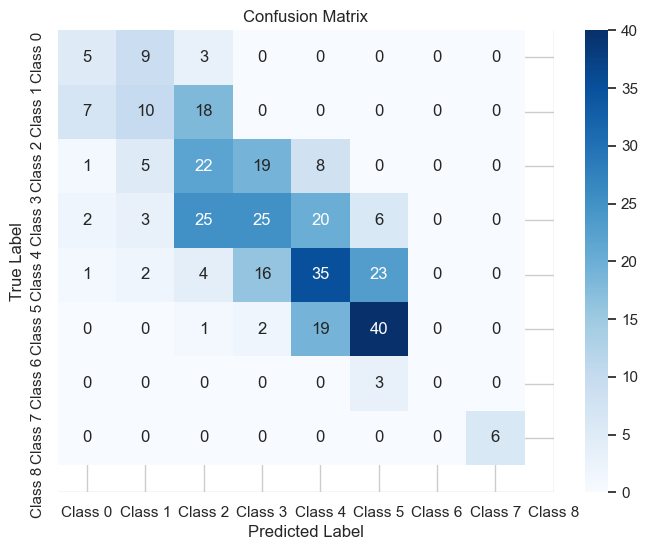

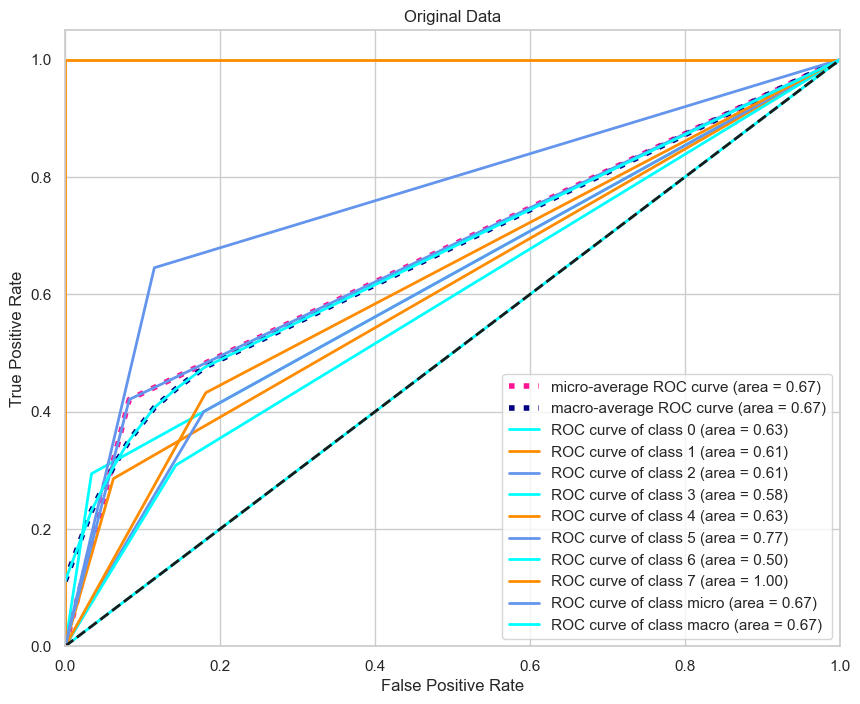

In [940]:
k_lgb = pd.DataFrame(results_lgb)
k_lgb = pd.concat([test_df[['LeagueIndex']], k_lgb],axis=1)

k_xgb = pd.DataFrame(results_xgb)
k_xgb = pd.concat([test_df[['LeagueIndex']], k_xgb],axis=1)

k_lgb['highest_prob_class'] = k_lgb.iloc[:, 1:].idxmax(axis=1)
k_xgb['highest_prob_class'] = k_xgb.iloc[:, 1:].idxmax(axis=1)

evaluation(k_lgb['LeagueIndex'],k_lgb['highest_prob_class'], "Original Data")

              precision    recall  f1-score   support

           0       0.30      0.47      0.36        17
           1       0.24      0.31      0.27        35
           2       0.31      0.40      0.35        55
           3       0.44      0.20      0.27        81
           4       0.43      0.37      0.40        81
           5       0.54      0.73      0.62        62
           6       0.50      0.33      0.40         3
           7       1.00      1.00      1.00         6

    accuracy                           0.41       340
   macro avg       0.47      0.48      0.46       340
weighted avg       0.42      0.41      0.40       340



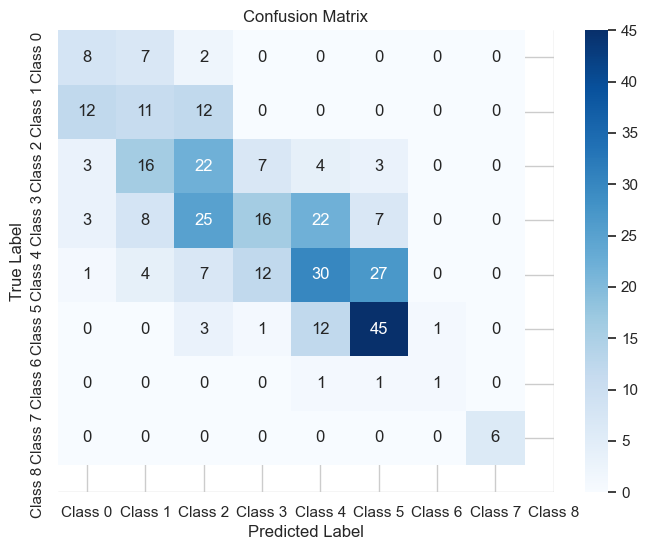

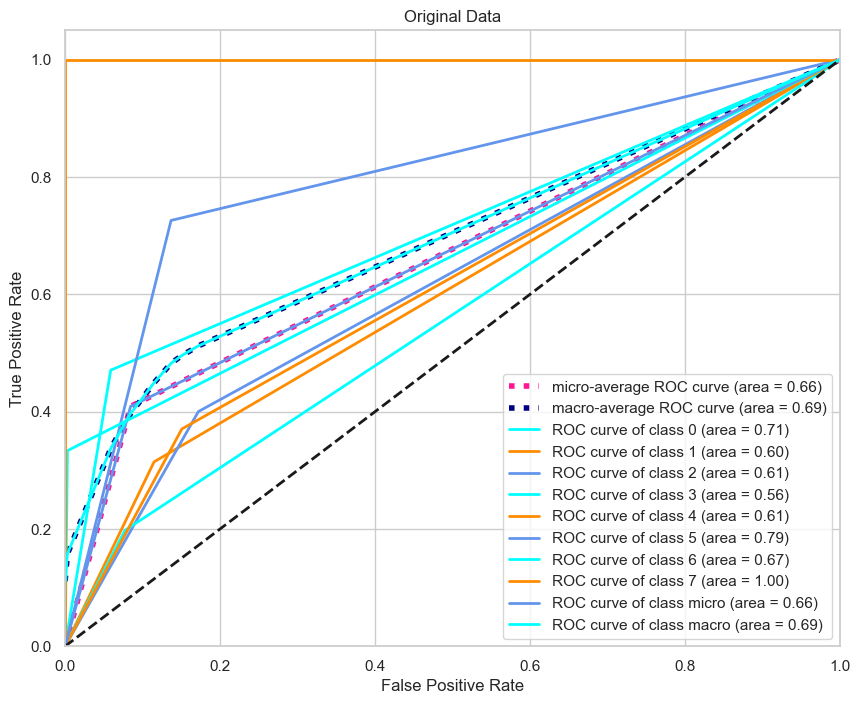

In [1035]:
evaluation(k_xgb['LeagueIndex'],k_xgb['highest_prob_class'], "Original Data")

# Clustering Methods

I will be using K Nearest Neighbours for the League Index multi-classification problem. I will be using Randomized Search CV to try out different hyperparameters in order to find out the best model. The hyperparemeters are-

- Randomly sample between 1 and 30 neighbors
- Choose between uniform or distance-based weights
- Choose between Manhattan distance (p=1) or Euclidean distance (p=2)
- Randomly sample between 20 and 50 for leaf size
- Choose between different algorithms
- Choose between different distance metrics

## Training/Validation on SMOTE oversampled dataset

In [1026]:
X = df_smote.drop(['LeagueIndex', 'GameID'], axis=1)
y = df_smote['LeagueIndex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [1027]:
# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': randint(1, 30), 
    'weights': ['uniform', 'distance'], 
    'p': [1, 2],
    'leaf_size': randint(20, 50),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan']
}

# Create the KNN model
knn = KNeighborsClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(knn, param_distributions=param_grid, n_iter=20, cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best model from the RandomizedSearchCV
best_knn = random_search.best_estimator_

# Predict the target variable using the best model
y_pred = best_knn.predict(X_test)

Best Parameters: {'algorithm': 'brute', 'leaf_size': 49, 'metric': 'manhattan', 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best Score: 0.6167525027265007


              precision    recall  f1-score   support

           0       0.78      0.94      0.85        81
           1       0.69      0.77      0.73        81
           2       0.58      0.64      0.61        81
           3       0.45      0.33      0.38        81
           4       0.40      0.28      0.33        81
           5       0.59      0.62      0.60        81
           6       0.91      1.00      0.95        82

    accuracy                           0.65       568
   macro avg       0.63      0.65      0.64       568
weighted avg       0.63      0.65      0.64       568



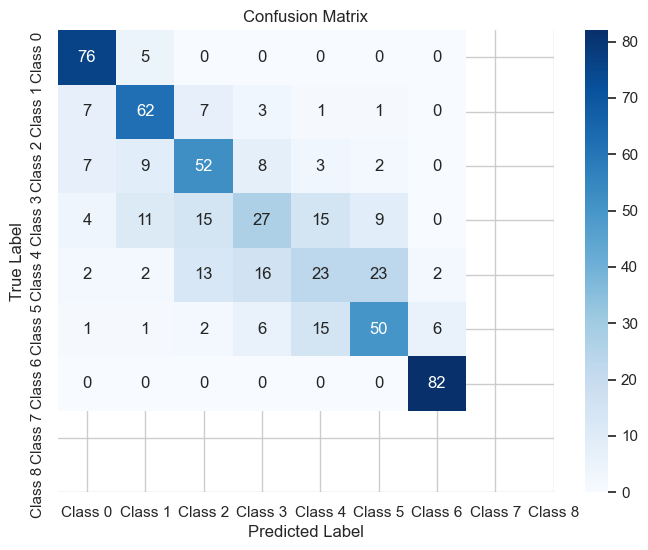

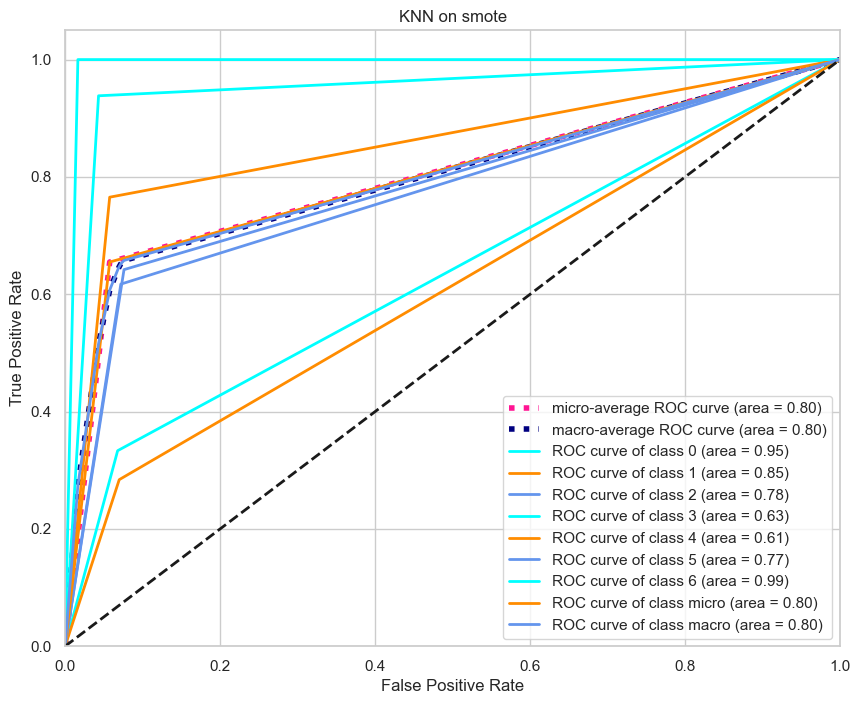

In [1028]:
evaluation(y_test,y_pred,"KNN on smote")

## Training Validation on Original Dataset

In [1030]:
df_knn = df.dropna()

In [1031]:
X = df_knn.drop(['LeagueIndex', 'GameID'], axis=1)
y = df_knn['LeagueIndex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [1032]:
# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': randint(1, 30), 
    'weights': ['uniform', 'distance'], 
    'p': [1, 2],
    'leaf_size': randint(20, 50),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan']
}

# Create the KNN model
knn = KNeighborsClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(knn, param_distributions=param_grid, n_iter=20, cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Get the best model from the RandomizedSearchCV
best_knn = random_search.best_estimator_

# Predict the target variable using the best model
y_pred = best_knn.predict(X_test)

Best Parameters: {'algorithm': 'auto', 'leaf_size': 21, 'metric': 'manhattan', 'n_neighbors': 28, 'p': 1, 'weights': 'distance'}
Best Score: 0.39281641708264003


              precision    recall  f1-score   support

           0       0.44      0.24      0.31        17
           1       0.38      0.26      0.31        35
           2       0.32      0.42      0.37        55
           3       0.39      0.48      0.43        81
           4       0.43      0.40      0.41        80
           5       0.63      0.55      0.59        62
           6       0.00      0.00      0.00         4

    accuracy                           0.42       334
   macro avg       0.37      0.33      0.34       334
weighted avg       0.43      0.42      0.42       334



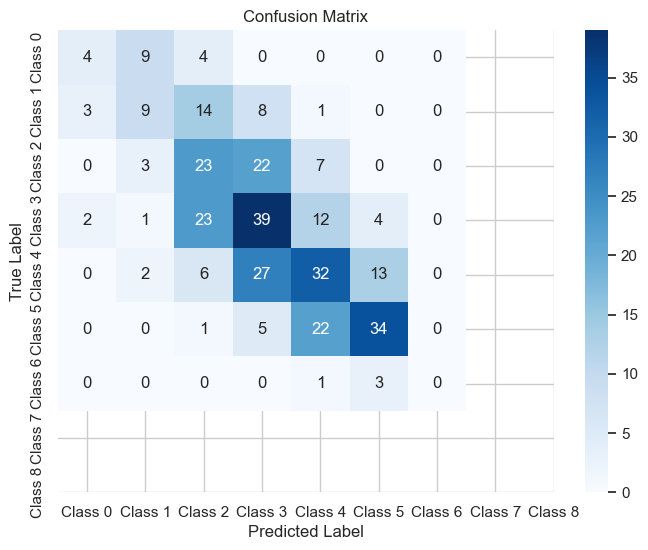

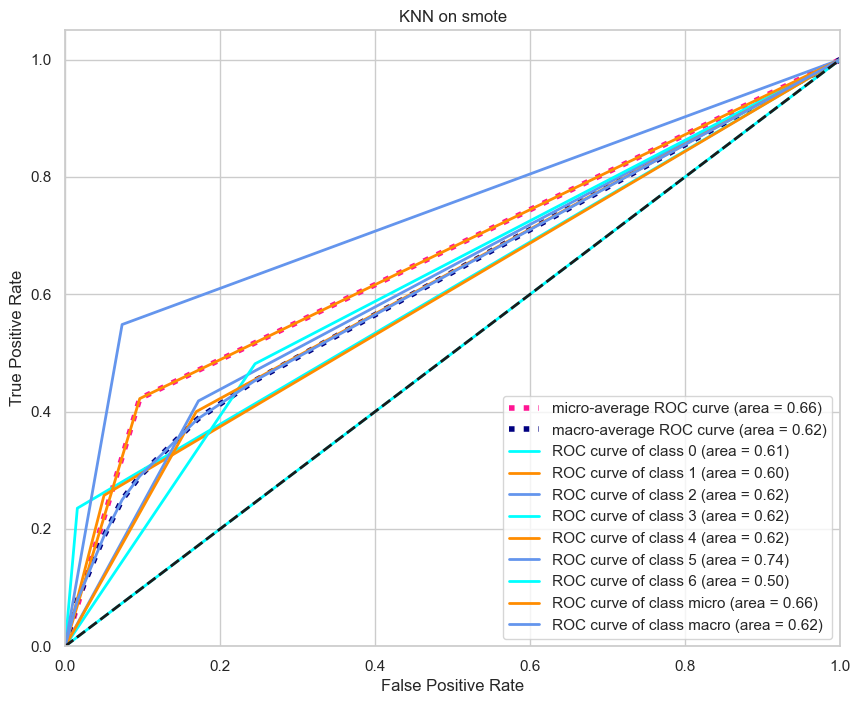

In [1033]:
evaluation(y_test,y_pred,"KNN on smote")

# Final Model Selection

Final observations are-

- SMOTE oversampled dataset is performing much better than the original dataset. Hence balancing the classes helped
- XGBoost model had a bad performance overall. The models were not able to find the right parameters without underfitting and overfitting the data.
- LightGBM model and KNN model trained on SMOTE oversampled data had high comparable performances, average 65% recall and 65% accuracy

### KNN model on SMOTE oversampled data is the final model selected

## Please find my final document named "Final_Findings.pdf"